# Homework 07 - Challenge

In this homework you will apply your knowledge to create the best possible neural network to solve the FashionMNIST dataset. You can use everything that you have learned so far.

The challenge is hosted on Kaggle: https://www.kaggle.com/t/26e38cf09340459cb798670a65c1e239

You have to download the files 'train.csv' and 'test.csv' and place them in the same folder as below. Then run the next two cells.

The first one imports all required libraries.  
The second one loads the training data and splits it up into training and validation data. You should use the validation data for testing whether you model is able to generalize.

The test data is only used to generate your submission files.

In [0]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import keras

In [123]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Load the training data and split up into training and validation data.
train_df = pd.read_csv('/content/drive/My Drive/train.csv')
train_images = np.reshape(train_df.values[:,1:], newshape=(-1,28,28))

# Preprocess Dataset
train_mean = np.mean(train_images)
train_stdev = np.std(train_images)
# subtract mean and divide by stdev
train_images = ((train_images - train_mean) / train_stdev)

train_labels = train_df.values[:,0]
val_images = train_images[50000:,:,:]
val_labels = train_labels[50000:]
train_images = train_images[:50000,:,:]
train_labels = train_labels[:50000]


class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [125]:
print(train_images.shape)
np.ptp(train_images[0])

(50000, 28, 28)


2.832666638445936

Ankle boot


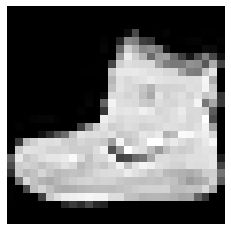

In [126]:
# Make sure the images are as desired:
print(class_names[int(train_labels[0])])
plt.imshow(train_images[0],cmap='gray')
plt.axis('off')
plt.show()


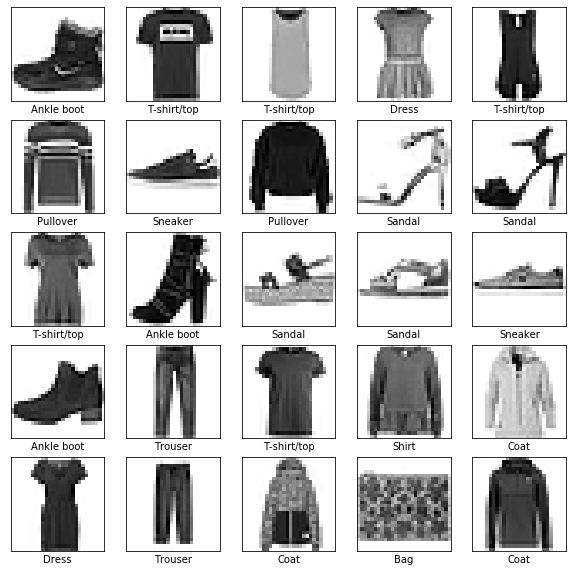

In [127]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[int(train_labels[i])])
plt.show()

In [0]:
#normalize
train_images = train_images.astype('float32') 
val_images = val_images.astype('float32') 

# Add a channels dimension
train_images = train_images[..., tf.newaxis]
val_images = val_images[..., tf.newaxis]

# reshape
train_images = train_images.reshape([-1, 28, 28, 1])
val_images = val_images.reshape([-1, 28, 28, 1])

# turn Labels into one hot
train_labels = keras.utils.np_utils.to_categorical(train_labels)
val_labels = keras.utils.np_utils.to_categorical(val_labels)

## Your Part

In the following section you can do whatever you want. The following code is only there to display how a trained model can later be used to generate a submission file.

You first should generate a tensorflow dataset and so on.

In [129]:
BATCHSIZE = 32
# create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
# Shuffle the training dataset.
train_dataset = train_dataset.shuffle(buffer_size=10000)
val_dataset = val_dataset.shuffle(buffer_size=10000)
# Use a batchsize of 32 for the training dataset.
train_dataset = train_dataset.batch(BATCHSIZE)
val_dataset = val_dataset.batch(BATCHSIZE)

val_dataset

<BatchDataset shapes: ((None, 28, 28, 1), (None, 10)), types: (tf.float32, tf.float32)>

In [0]:
l_relu = tf.keras.layers.LeakyReLU(alpha=0.2)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 32, kernel_size=3, padding="same", activation= 'relu', input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(pool_size =(2,2), strides= (2,2)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(filters = 64, kernel_size=3, padding="same", activation= 'relu', strides= (2,2)),
    tf.keras.layers.MaxPool2D(pool_size =(2,2), strides= (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1024, activation='relu'),
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [131]:
tf.keras.backend.clear_session()
#model = Model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              5

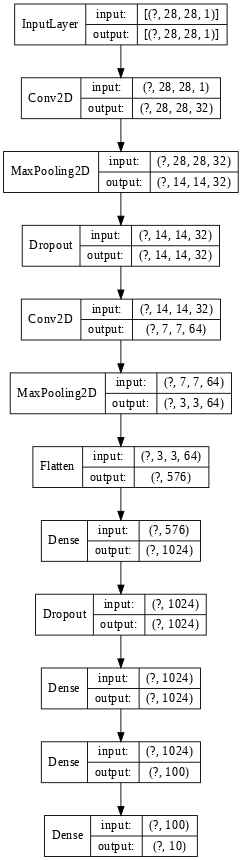

In [132]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=False,
    rankdir='TB',
    expand_nested=False,
    dpi=64
)

In [0]:
# Defining loss function as categorical crossentropy
cce = tf.keras.losses.CategoricalCrossentropy()
scce = tf.keras.losses.SparseCategoricalCrossentropy() #seems like that doesnt work with one-hot encoding, only integers
loss = cce

# Define optimizer as adam with default parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.8, epsilon=1e-06,) # standard parameters: learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,

# Initialize lists for later visualiztion
train_steps = []
train_losses = []
train_accuracies = []
test_steps = []
test_losses = []
test_accuracies = []
loss_steps = []
step = 0

In [0]:
def visualize(epoch):
    # final scores
    print('Median Training Loss: ',np.median(np.array(train_losses[-150:-1])))
    print('Median Training Accuracy: ',np.median(np.array(train_accuracies[-50:-1])))
    print('Median Validation Loss: ',np.median(np.array(test_losses[-50:-1])))
    print('Median Validation Accuracy: ',np.median(np.array(test_accuracies[-50:-1])))

    if epoch == EPOCHS-1:
        # training loss graph
        fig = plt.figure(figsize=(15,6))
        plt.subplots_adjust(hspace = 0.4)
        a=fig.add_subplot(2,2,1)
        # training loss
        plt.plot(loss_steps, np.array(train_losses))
        plt.title('Traing Loss')
        plt.xlabel("Steps")
        plt.ylabel("Loss")

        # training accuracy graph
        a=fig.add_subplot(2,2,2)
        # training accuracy
        plt.plot(train_steps, np.array(train_accuracies))
        plt.title('Training Accuracy')
        plt.xlabel("Steps")
        plt.ylabel("Accuracy")

        # test loss graph
        a=fig.add_subplot(2,2,3)
        # testing loss
        plt.plot(test_steps, np.array(test_losses))
        plt.title('Test Loss')
        plt.xlabel("Steps")
        plt.ylabel("Loss")

        # test accuracy graph
        a=fig.add_subplot(2,2,4)
        # test accuracy
        plt.plot(test_steps, np.array(test_accuracies))
        plt.title('Test Accuracy')
        plt.xlabel("Steps")
        plt.ylabel("Accuracy")

        plt.show()

Current Epoch: 0
Median Training Loss:  0.31261587
Median Training Accuracy:  0.8125
Median Validation Loss:  0.31289244
Median Validation Accuracy:  0.875
Current Epoch: 1
Median Training Loss:  0.26771107
Median Training Accuracy:  0.90625
Median Validation Loss:  0.27539164
Median Validation Accuracy:  0.875
Current Epoch: 2
Median Training Loss:  0.21390489
Median Training Accuracy:  0.90625
Median Validation Loss:  0.26917738
Median Validation Accuracy:  0.90625
Current Epoch: 3
Median Training Loss:  0.19325489
Median Training Accuracy:  0.9375
Median Validation Loss:  0.28834748
Median Validation Accuracy:  0.90625
Current Epoch: 4
Median Training Loss:  0.1767955
Median Training Accuracy:  0.90625
Median Validation Loss:  0.28066254
Median Validation Accuracy:  0.90625
Current Epoch: 5
Median Training Loss:  0.16257927
Median Training Accuracy:  0.9375
Median Validation Loss:  0.25816935
Median Validation Accuracy:  0.90625


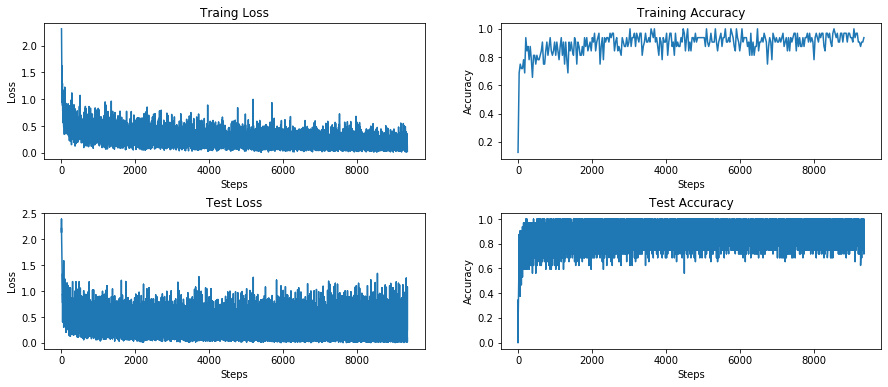

In [135]:
EPOCHS = 6
for epoch in range(EPOCHS):
    print('Current Epoch: ' + str(epoch))

    for (x,t) in train_dataset:
        # Perform a training step.
        # Compute the output, loss and the gradients.
        with tf.GradientTape() as tape:
            output = model(x)
            train_loss = loss(t, output)
            gradients = tape.gradient(train_loss, model.trainable_variables)
        
        # After recording the gradients we can apply them to the variables.
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))     
        # Store loss
        train_losses.append(train_loss)
        loss_steps.append(step)
        
        # Calculate the training accuracy every 25 steps.
        if step % 30 == 0:
            # Compute the accuracy.
            acc = tf.keras.metrics.CategoricalAccuracy( name='acc')
            acc.update_state(t, output)
            accuracy = acc.result().numpy()
            # save for later visualisation
            train_accuracies.append(accuracy)
            train_steps.append(step)
            # Calculate the test loss and accuracy
            for (x,t) in val_dataset:
                output = model(x)
                # then compute loss and accuracy
                test_loss = loss(t, output)
                acc = tf.keras.metrics.CategoricalAccuracy( name='acc')
                acc.update_state(t, output)
                accuracy = acc.result().numpy()

                # save for later visualisation
                test_steps.append(step)
                test_accuracies.append(accuracy)
                test_losses.append(test_loss)     
        step += 1
    visualize(epoch) 

### Generate Submission File (Do not change anything here!)

In [0]:
from datetime import datetime
now = datetime.now()
now_str = now.strftime('%d-%m-%Y-%H:%M:%S')

# Load the test data.
test_df = pd.read_csv('/content/drive/My Drive/test.csv')
test_images = np.reshape(test_df.values[:,:], newshape=[-1, 28, 28, 1])

# Preprocess Dataset
# subtract mean and divide by stdev
test_images = ((test_images - train_mean) / train_stdev)

test_images = test_images.astype('float32') 

# Get predictions.
output = model(test_images, training = False).numpy()
predictions = np.argmax(output, axis=1)

# Save submission file.
submission_data = np.zeros((10000,2), dtype=np.int)
submission_data[:,0] = np.arange(10000)
submission_data[:,1] = predictions
df_submission = pd.DataFrame(data=submission_data, columns=['ImageId','Prediction'], dtype=str)

#df_submission.set_index('ImageId', drop = True, inplace = True)
df_submission.head()
df_submission.to_csv('submission-'+ now_str +'.csv')